# Stream

Computing time comparison between different data structures :
* numpy arrays
* dictionaries (cythonized)

To compare these structures, we perform dot-product on sparse matrix.

**Libraries**

In [1]:
from scipy import sparse
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns

**Functions**

In [61]:
def create_sparse_matrix(n, density):
    m = n
    size = int(n * m * density)
    
    rows = np.random.randint(0, n, size=size)
    cols = np.random.randint(0, m, size=size)
    data = np.random.randint(1, 2, size)
    
    return sparse.csr_matrix((data, (rows, cols)), shape=(n, m))

def plot_time(times, ax):
    ax.plot(range(len(times)), times, label='time', marker='o')
    ax.set_title('Dot-product computation time')
    ax.set_xlabel('Nb nodes')
    ax.set_ylabel('Time')
    ax.legend();
    
def plot_history(history, ax):
    ax.boxplot(history.values())
    ax.set_xticklabels(history.keys())
    ax.set_title('Dot-product computation time', weight='bold')
    ax.set_ylabel('Time');

## 1. Using Numpy

In [241]:
nb_nodes = 1000
density = 0.001

A = create_sparse_matrix(nb_nodes, density)
v = np.random.randn(nb_nodes)

In [242]:
ns = [1e3, 1e4, 5e4, 1e5]#, 1e6]
history = defaultdict(list)

for n in ns:
    for i in range(5):
        nb_nodes = int(n)
        density = 0.001

        A = create_sparse_matrix(nb_nodes, density)
        v = np.random.randn(nb_nodes)

        # Dot product
        start = time.time()
        res = A.dot(v)
        end = time.time()
        history[n].append(end-start)

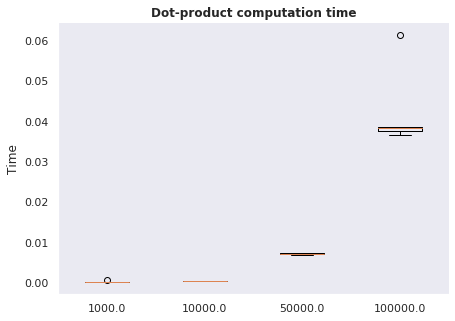

In [243]:
# Plots
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_history(history, ax=ax)

In [153]:
df_numpy = pd.melt(pd.DataFrame(history))
df_numpy['method'] = 'numpy'

## 2. Using dictionaries

In [134]:
def csr2dict(csr_matrix):
    ''' For each row in adjacency matrix and if the row does contain non zero values,
        we retrieve columns where values are non zeros, and add corresponding data to adjacency dictionary '''
    
    # Initalize adjacency as a dictionary (of dictionary)
    adj = {}
    
    # Fill adjacency dictionary
    for i in range(1, len(csr_matrix.indptr)-1):
        if (csr_matrix.indptr[i] - csr_matrix.indptr[i-1]>0):
            columns = csr_matrix.indices[csr_matrix.indptr[i-1]:csr_matrix.indptr[i]]
            data = csr_matrix.data[csr_matrix.indptr[i-1]:csr_matrix.indptr[i]]
            adj[i-1] = {col: val for col, val in zip(columns, data)}
            
    return adj

def vecmul(adj, v):
    ''' Matrix-vector product with dictionaries. '''
    
    res = {}
    
    for key, value in adj.items():
        for key_col, value_col in value.items():
            res[key] = res.get(key, 0) + value_col*v[key_col]
    
    return res

In [162]:
ns = [1e3]#, 1e4]#, 5e4]#, 1e5]#, 1e6]
history = defaultdict(list)

for n in ns:
    for i in range(5):
        nb_nodes = int(n)
        density = 0.001

        # CSR adjacency
        A = create_sparse_matrix(nb_nodes, density)
        # Random vector
        v = {k: v for k, v in enumerate(np.random.rand(A.shape[0]))}

        # Dictionary adjacency
        adj = csr2dict(A)
        
        # Dot-product with dict
        start = time.time()
        res = vecmul(adj, v)
        end = time.time()
        history[n].append(end-start)

In [164]:
df_dict = pd.melt(pd.DataFrame(history))
df_dict['method'] = 'dictionaries'

**Comparison**

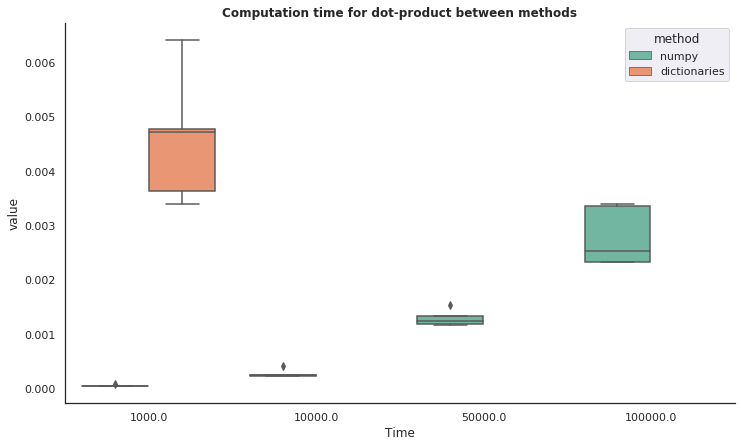

In [185]:
df_tot = pd.concat([df_numpy, df_dict])

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="dark", rc=custom_params)
sns.boxplot( data=df_tot, y='value', x='variable', hue='method', ax=ax, palette="Set2")
plt.xlabel('Time')
plt.title('Computation time for dot-product between methods', weight='bold');

## 3. Cythonized dictionaries

In [194]:
import cython

In [190]:
%load_ext Cython

In [238]:
%%cython -a

def vecmul_cy(dict adj, dict v):
    ''' Matrix-vector product with dictionaries. '''
    
    res={}
    
    for key, value in adj.items():
        for key_col, value_col in value.items():
            res[key] = res.get(key, 0) + value_col*v[key_col]
    
    return res

In [239]:
history = []
for i in range(5):
    ns: cython.int = 1000
    nb_nodes: cython.int = ns
    density: cython.float = 0.001

    # CSR adjacency
    A = create_sparse_matrix(nb_nodes, density)
    # Random vector
    v = {k: v for k, v in enumerate(np.random.rand(A.shape[0]))}

    # Dictionary adjacency
    adj = csr2dict(A)

    # Dot-product with dict
    start = time.time()
    res = vecmul_cy(adj, v)
    end = time.time()
    history.append(end-start)

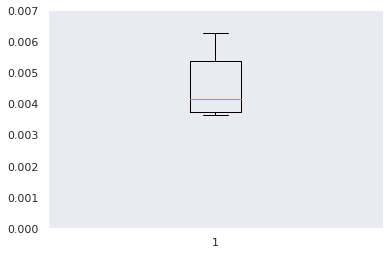

In [240]:
fig, ax = plt.subplots(1, 1)
ax.boxplot(history)
ax.set_ylim(0, 0.007);